<a href="https://colab.research.google.com/github/avijit-mukherjee-25/transformers/blob/main/Transformer_to_classify_MNIST_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install libraries
!pip install transformers torch numpy datasets evaluate matplotlib

## Import dependencies

In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## Get global hyper params

In [3]:
batch_size = 32
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-4
num_epochs = 10
num_heads = 4
num_layers = 4
d_model = 512

## Get Data

In [4]:
train_dataset = datasets.MNIST(root="./datasets/", train=True, download=True, transform=ToTensor())
test_dataset = datasets.MNIST(root="./datasets/", train=False, download=True, transform=ToTensor())

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 346kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.76MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.38MB/s]


In [5]:
train_dataset, test_dataset

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./datasets/
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ./datasets/
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [6]:
# nornalize the data
imgs = torch.stack([img for img, _ in train_dataset], dim=0)
print (imgs.shape)
mean = imgs.view(1, -1).mean(dim=1)
std = imgs.view(1, -1).std(dim=1)
print (mean, std)

torch.Size([60000, 1, 28, 28])
tensor([0.1307]) tensor([0.3081])


In [7]:
# transform data
mnist_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])

In [8]:
train_dataset = datasets.MNIST(root="./datasets/", train=True, download=False, transform=mnist_transforms)
test_dataset = datasets.MNIST(root="./datasets/", train=False, download=False, transform=mnist_transforms)
train_dataset, test_dataset

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./datasets/
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=tensor([0.1307]), std=tensor([0.3081]))
            ),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ./datasets/
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=tensor([0.1307]), std=tensor([0.3081]))
            ))

44202
torch.Size([1, 28, 28])
8


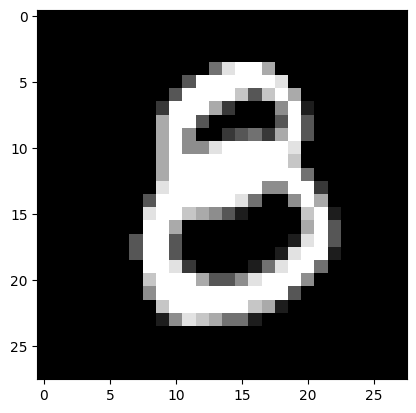

In [9]:
# pick a random image and plot
random_idx = np.random.randint(0, len(train_dataset))
print (random_idx)

img, label = train_dataset[random_idx]
print (img.shape)
plt.imshow(img.squeeze(), cmap='gray')
print (label)

In [10]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

# Let's see no of batches that we have now with the current batch-size
print (len(train_dataloader), len(test_dataloader))
print (len(train_dataset), len(train_dataloader.dataset))

1875 313
60000 60000


## Define train and test functions

In [13]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" an

In [14]:
import evaluate

In [15]:
def train(model, optimizer, loss_fn, train_dataloader):
    train_loss = 0.0
    model.train()
    metric = evaluate.load("accuracy")
    for step, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        logits = model(X)
        loss = loss_fn(logits, y)
        train_loss += loss.item()
        metric.add_batch(predictions=logits.argmax(dim=1), references=y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if step%1000==0:
            print (f'training loss at {step} is {train_loss}')
    train_accuracy = metric.compute()
    return train_loss, train_accuracy

In [16]:
@torch.no_grad()
def eval(model, test_dataloader):
    model.eval()
    metric = evaluate.load("accuracy")
    test_loss = 0.0
    for _, (X, y) in enumerate(test_dataloader):
        X, y = X.to(device), y.to(device)
        logits = model(X)
        loss = loss_fn(logits, y)
        test_loss += loss.item()
        metric.add_batch(predictions=logits.argmax(dim=1), references=y)
    test_accuracy = metric.compute()
    model.train()
    return test_loss, test_accuracy

## LeNet

In [17]:
# define the model
class LeNet(nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel (black & white), 6 output channels, 5x5 square convolution
        # kernel
        self.feature = nn.Sequential(
            #1
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),   # 28*28->32*32-->28*28
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 14*14

            #2
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),  # 10*10
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 5*5

        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=10),
        )

    def forward(self, x):
        return self.classifier(self.feature(x))

LeNet_model = LeNet()
LeNet_model.to(device)

LeNet(
  (feature): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=400, out_features=120, bias=True)
    (2): Tanh()
    (3): Linear(in_features=120, out_features=84, bias=True)
    (4): Tanh()
    (5): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [20]:
# hyperparams
from torch.optim import AdamW
optimizer = AdamW(LeNet_model.parameters(), lr=learning_rate)

In [21]:
for epoch in range(num_epochs):
    print (f'Epoch: {epoch}')
    train_loss, train_accuracy = train(LeNet_model, optimizer, loss_fn, train_dataloader)
    print (f'train loss at epoch {epoch} is {train_loss}; train accuracy is {train_accuracy}')
    test_loss, test_accuracy = eval(LeNet_model, test_dataloader)
    print (f'test loss at epoch {epoch} is {test_loss}; test accuracy is {test_accuracy}')

Epoch: 0


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


training loss at 0 is 2.316706657409668
training loss at 1000 is 838.6995326429605
train loss at epoch 0 is 1121.2670070305467; train accuracy is {'accuracy': 0.8514833333333334}
test loss at epoch 0 is 81.08765929564834; test accuracy is {'accuracy': 0.9266}
Epoch: 1
training loss at 0 is 0.25561198592185974
training loss at 1000 is 230.7419107183814
train loss at epoch 1 is 387.46535235084593; train accuracy is {'accuracy': 0.94095}
test loss at epoch 1 is 47.099928312934935; test accuracy is {'accuracy': 0.9557}
Epoch: 2
training loss at 0 is 0.07824619114398956
training loss at 1000 is 139.737482143566
train loss at epoch 2 is 242.28551035001874; train accuracy is {'accuracy': 0.96225}
test loss at epoch 2 is 30.864707176107913; test accuracy is {'accuracy': 0.9708}
Epoch: 3
training loss at 0 is 0.0449061281979084
training loss at 1000 is 98.67838882515207
train loss at epoch 3 is 174.50158100784756; train accuracy is {'accuracy': 0.97305}
test loss at epoch 3 is 24.80939735565334

## ViT

In [23]:
# define the model
class ViT(nn.Module):

    def __init__(self, num_heads, num_layers, d_model):
        super(ViT, self).__init__()
        self.conv = nn.Sequential(
            #1 conv
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),   # 28*28->32*32-->28*28
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # batch_size*out_channels*14*14

            #2 conv
            nn.Conv2d(in_channels=6, out_channels=d_model, kernel_size=5, stride=1),  # 10*10
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # batch_size*out_channels*5*5
        )
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(
               d_model=d_model, nhead=num_heads,
               dim_feedforward=int(d_model * 4),
               dropout=0.1,
               batch_first = True
        )
        self.transformer_encoder = nn.TransformerEncoder(
                   encoder_layer=self.transformer_encoder_layer,
                   num_layers=num_layers
        )
        self.linear = nn.Linear(d_model, 10)

    def forward(self, x):
        x = self.conv(x) # --> batch_size*d_model*5*5
        x = x.flatten(start_dim=2).permute(0,2,1) # --> batch_size*seq*d_model

        _batch_size = x.shape[0]
        cls_token = nn.Parameter(torch.randn(1, 1, d_model)).to(device)
        cls_tokens = cls_token.expand(_batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        _batch_size, _seq_len, _ = x.shape
        x += nn.Parameter(torch.randn(_batch_size, _seq_len, d_model)).to(device)

        x = self.transformer_encoder(x) # --> batch_size*(seq+1)*d_model

        out = self.linear(x[:,0,:])

        return out

ViT_model = ViT(num_heads, num_layers, d_model)
ViT_model.to(device)

ViT(
  (conv): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 512, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (transformer_encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (linear1): Linear(in_features=512, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=512, bias=True)
    (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x

In [24]:
from torch.optim import AdamW
optimizer = AdamW(ViT_model.parameters(), lr=1e-4)

In [25]:
for epoch in range(num_epochs):
    print (f'Epoch: {epoch}')
    train_loss, train_accuracy = train(ViT_model, optimizer, loss_fn, train_dataloader)
    print (f'train loss at epoch {epoch} is {train_loss}; train accuracy is {train_accuracy}')
    test_loss, test_accuracy = eval(ViT_model, test_dataloader)
    print (f'test loss at epoch {epoch} is {test_loss}; test accuracy is {test_accuracy}')

Epoch: 0
training loss at 0 is 2.660102367401123
training loss at 1000 is 1495.17106834054
train loss at epoch 0 is 1964.7569263465703; train accuracy is {'accuracy': 0.6247666666666667}
test loss at epoch 0 is 122.87177383899689; test accuracy is {'accuracy': 0.8752}
Epoch: 1
training loss at 0 is 0.12336736172437668
training loss at 1000 is 363.11730578914285
train loss at epoch 1 is 612.6179596465081; train accuracy is {'accuracy': 0.8949666666666667}
test loss at epoch 1 is 76.76884283870459; test accuracy is {'accuracy': 0.9203}
Epoch: 2
training loss at 0 is 0.1783221811056137
training loss at 1000 is 247.70130956172943
train loss at epoch 2 is 434.7893942017108; train accuracy is {'accuracy': 0.9266333333333333}
test loss at epoch 2 is 76.6372586004436; test accuracy is {'accuracy': 0.9194}
Epoch: 3
training loss at 0 is 0.3917463421821594
training loss at 1000 is 196.46282479912043
train loss at epoch 3 is 355.7215439444408; train accuracy is {'accuracy': 0.9402166666666667}
te